# Tinkering Notebook 6 - Policy Gradient

This notebook focuses on policy gradient methods. In the notebook, we will implement REINFORCE, REINFORCE with a baseline and One-step Actor-Critic. 

Note that the code in the notebook does not average over several runs, so the results can deviate from the corresponding examples in the textbook on each run (especially for methods with high variance). Thus you should re-run all examples several times, and possibly add code to do averaging. 

# Table of content
* ### [1. Imports ](#sec1)
* ### [2. The short corridor environment](#sec2)
* ### [3. REINFORCE (with baseline)](#sec3)
 * #### [3.1 Without a baseline](#sec3_1)
 * #### [3.2 With baseline](#sec3_2)
* ### [4. One-step Actorc-Critic](#sec4)


# 1. Imports  <a id="sec1">

In [1]:
import gymnasium as gym 
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import gym_RLcourse
from IPython.display import clear_output # Used to clear the ouput of a Jupyter cell.

# 2. The short corridor environment <a id="sec2">

In this notebook we will use the short corridor environment discussed in Example 13.1 of the textbook.

In [2]:
env = gym.make('ShortCorridor-v0', render_mode="human")
state, info = env.reset()
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(4)
Action space: Discrete(2)


The environment has three non-terminal states and 2 actions (left or right).

In [3]:
LEFT = 0
RIGHT = 1

The meaning of these are exactly as they sound

In [6]:
state, reward, terminated, truncated, info = env.step(RIGHT)
print('Reward:', reward)

Reward: -1


However, in the middle non-terminal state, the actions are reversed. Hence, if we go `RIGHT` again we will end up at the start.

In [8]:
state, reward, terminated, truncated, info = env.step(RIGHT)
print('Reward:', reward)

Reward: -1


Finally we close the environment to close the graphical window. 

In [9]:
env.close()

This is a simple environment to solve and any tabular RL method can handle it.

However, to be able to determine the optimal action to take we must know what state we are in. Now assume that we use function approximation with the features 

$$
\mathbf{x}(s, RIGHT) = \begin{bmatrix} 1 \\ 0 \end{bmatrix}, \quad \mathbf{x}(s, LEFT) = \begin{bmatrix} 0 \\ 1 \end{bmatrix} \quad \text{for all } s
$$

Notice that with these features the agent is not able to differentiate between the states based on only looking at the features. Hence, a policy based on these features must choose the action without knowing which state it is in (with these features the agent is blind).

For example, if we find a policy by first estimating $\hat{q}$ with linear function approximation then we get

$$
\hat{q}(s,a,\mathbf{w}) = \mathbf{w}^\top \mathbf{x}(s,a) = \begin{cases} w_1 & \text{if } a = RIGHT \\ w_2 & \text{if } a = LEFT\end{cases}
$$
Hence, the greedy action w.r.t to $\hat{q}$ would be always `RIGHT` if $w_1 > w_2$ and always `LEFT` if $w_2 > w_1$. However, such a policy would never reach the goal in this environment. Hence, when the agent uses these features a stochastic policy is needed, and the goal is to learn the optimal probability for `RIGHT` vs `LEFT`. 

___Remark:___ Of course, the features we use here are not very good for this environment, since they lose all information about what state we are in. However, it is an interesting example for two reasons:
1. It gives us a simple situation to experiment with where the optimal policy is stochastic. 
2. In a real scenario it may be the case that we have no way of knowing what the current state is, and we thus have to pick an action without knowing the state. With the features described above we end up in this situation. In the code we use below, you will see that the information about the current state is never actually used by the agent. 

# 3. REINFORCE (with baseline) <a id="sec3">

In this section we will implement the REINFORCE algorithm (potentially with $\hat{v}(s, \mathbf{w})$ as a baseline). For this we will implement three classes (SC stands for short corridor):

1. `PolicySC` which implements the policy $\pi(a|s, \boldsymbol{\theta})$. Here we will implement a soft-max policy with linear preferences using the features discussed in the previous section. The class has one method that returns the probability for each action with the current $\boldsymbol{\theta}$, one method that picks an action according to these probabilities, and one method for computing $\nabla \ln \pi(a|s, \boldsymbol{\theta})$.

2. `ValueFunctionSC` which implements the estimate $\hat{v}(s, \mathbf{w})$ (used as a baseline). Here we implement a very simple function estimator with just one weight (scalar) $\hat{v}(s, w) = w$. The function has one method for computing $\hat{v}(s, w)$ and one for computing $\nabla \hat{v}(s, w)$. Note that with this approximation we give the same approximated value to all states (since the agent cannot differentiate between the states).

3. `REINFORCE` implements acting and learning. We will assume that $\gamma = 1$ in the implementation (see e.g. algorithms in lecture slides), but if you want you can extend it to handle the case when $\gamma < 1$ by looking at the algorithms in the textbook.

In [10]:
class PolicySC:
    
    def __init__(self):
        
        self.actions = np.array([0, 1])
        self.theta = np.array([ -1.47, 1.47]) # Initially higher preference for LEFT (theta[1]) than RIGHT (theta[0])
        self.features = np.array([[0, 1], [1, 0]])  # self.features[:, 0] for left and self.features[:,1] for right.
        
    def a_probs(self, state):
        # Compute softmax(theta^T * features) for all a 
        h = np.dot(self.theta, self.features)
        return softmax(h)
    
    def act(self, state):
        return np.random.choice(self.actions, p=self.a_probs(state))
    
    def ln_grad(self, state, action):
        # See "Exercises on policy-gradient methods" or equation (13.9) in textbook
        # Also note that in this example the features do not depend on the state
        return self.features[:, action] - np.dot(self.features, self.a_probs(state))

__TASK__: Make sure that you understand `PolicySC`. Note that `a_probs` returns an array with probability for taking left or right. With the initial $\boldsymbol{\theta}$ the probabilities are given by

In [12]:
policy = PolicySC()
print("Probabilities:", policy.a_probs(0)) 
print("Probability for LEFT: %.2f" % (policy.a_probs(0)[0]))
print("Probability for RIGHT: %.2f" % (policy.a_probs(0)[1]))

Probabilities: [0.94978873 0.05021127]
Probability for LEFT: 0.95
Probability for RIGHT: 0.05


To get one action with these probabilities we can use: (note that you will get `LEFT=0` about 95% of the time, and `RIGHT=1` only around 5% of the time

In [14]:
print("Random action:", policy.act(0))

Random action: 0


In [15]:
class ValueFunctionSC:
    
    def __init__(self):
        self.w = 0
        
    def value(self, state):
        return self.w
    
    def grad(self, state):
        return 1 

__TASK__: Make sure you understand `ValueFunctionSC`. Note that here we use the very simple function approximation $\hat{v}(s, w) = w$ for all $s$.

In [16]:
class REINFORCE:
    
    def __init__(self, policy, valuefunc, alpha_theta=(2**-13), alpha_w = (2**-6), baseline=False):
        
        self.alpha_theta = alpha_theta
        self.alpha_w = alpha_w
        self.baseline = baseline
        
        self.policy = policy
        self.valuefunc = valuefunc
        
    def act(self, state):
        return self.policy.act(state)
        
    def learn(self, states, actions, rewards):
        T = len(states)
        
        for t in range(0,T-1):
            Gt = np.sum(rewards[t+1:T])
            state = states[t]
            action = actions[t]
            
            if self.baseline:
                delta = Gt - self.valuefunc.value(state)
                self.valuefunc.w += self.alpha_w*delta*self.valuefunc.grad(state)
                self.policy.theta += self.alpha_theta*delta*self.policy.ln_grad(state, action)
            else:
                # TODO Implement update for REINFORCE without baseline
                self.policy.theta += self.alpha_theta * Gt * self.policy.ln_grad(state, action)

__TASK__: 
1. Make sure that you understand the code in `REINFORCE`. 
2. Write the code for updating $\boldsymbol{\theta}$ when there is no baseline.

Finally, we write a function for training our `REINFORCE`-agent. It will run a full episode using the policy `agent.act` and then send all states, rewards, and actions seen in the episode to `agent.learn`. 

In [17]:
def train(env, agent, n_episodes):
    
    total_reward = -1000*np.ones(n_episodes)
    print('Episode 1')
    for i in range(n_episodes):
        
        if ((i+1) % 100) == 0:
            clear_output(wait=True)
            print('Episode', i+1)
            
        state, info = env.reset()
        
        states = [state]
        actions = []
        rewards = [0] # rewards[0] is never used.
        
        terminated = truncated = False
        
        while not terminated and not truncated:
            action = agent.act(state)
            actions.append(action)
            state, reward, terminated, truncated, info = env.step(action)
            
            states.append(state)
            rewards.append(reward)
            
        if truncated:
            print('An episode was truncated, so the training stop at episode', i)
            return (total_reward, True)
        
        agent.learn(states, actions, rewards)
        total_reward[i] = np.sum(rewards)
        
    return (total_reward, False)

### A reamrk on truncation

One problem with the given environment is that with a deterministic policy, the agent will never reach the goal. Even with a policy that is close to deterministic (let's say 99.9% for left and 0.01% for right) it may take a very long time for the agent to reach the goal. For this reason, `ShortCorridor-v0` will truncate the episode if the goal is not reached within 1000 steps. 

This however means that we were not able to finish the episode, and therefore we cannot compute returns. For this reason `train` will stop the training if an episode is truncated.

Below you will see that larger step sizes usually lead to faster learning, but also increase the risk that the agent gets stuck with an almost deterministic policy and thus never learns the optimal policy. 

## 3.1 Without a baseline <a id="sec3_1">

We first create an environment to train in 

In [18]:
env_train = gym.make('ShortCorridor-v0')

Finally we run the training. This may take a few seconds, so wait until it says `Finished`. 

In [59]:
n_episodes = 10000
alpha_theta = 2**(-14)
policy = PolicySC()
valuefunc = ValueFunctionSC()
agent = REINFORCE(policy, valuefunc, alpha_theta=alpha_theta, baseline=False)
total_reward, truncated = train(env_train, agent, n_episodes)
print('Finished')

Episode 10000
Finished


We now plot the total reward received in every episode. The yellow dashed line shows the optimal average reward. Note that you can higher total reward than the optimal average reward in individual episodes but on average it is not possible to do better. 

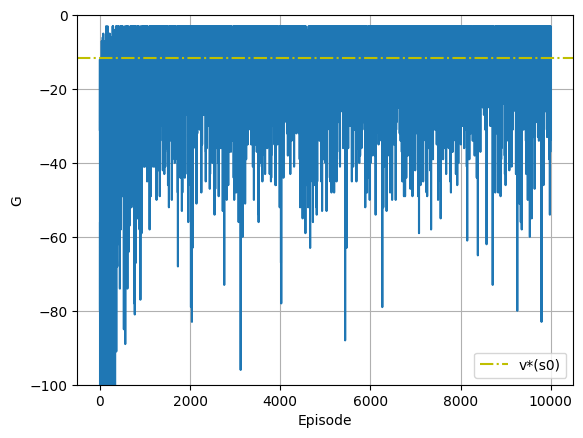

In [60]:
plt.plot(total_reward) 
plt.axhline(y=-11.6, color='y', linestyle='-.', label='v*(s0)')
plt.xlabel('Episode')
plt.ylabel('G')
plt.legend(loc='best')
plt.ylim(-100, 0)
plt.grid(True)

It may also be of interest to see the what probabilities the agent has learned for each action. 

In [61]:
print('Estimated theta:', agent.policy.theta)
print('Probability for LEFT: %.2f' % ( agent.policy.a_probs(0)[LEFT]))
print('Probability for RIGHT: %.2f' % ( agent.policy.a_probs(0)[RIGHT]))

Estimated theta: [ 0.16161005 -0.16161005]
Probability for LEFT: 0.42
Probability for RIGHT: 0.58


This can be compared with the initial probabilities (0.95 for `LEFT` and 0.05 for `RIGHT`) and the optimal probabilities (0.41 for `LEFT` and 0.59 for `RIGHT`).

__Task__: 
1. Re-run the code cells above a few times to see how the results vary, both when it comes to rewards and the estimated probabilities after 1000 time steps. 

2. Try to change the step-length $\alpha_\theta$. Try at least $\alpha_\theta = 2^{-14}, 2^{-13}, 2^{-12}, 2^{-9}$. For each choice, re-run the code a few times. 

3. Compare your results with that of Figure 13.1 in the textbook. Note that the results in the textbook show the average results over 100 independent runs. Can you explain why $\alpha = 2^{-12}$ gives much worse average result than $2^{-13}$ and $2^{-14}$ in the figure? (The remark below may be relevant when you reason about this).

4. It may also be of interest to train for more episodes. Try e.g. using $\alpha_\theta = 2^{-14}$ with 10 000 episodes. (Note, that even if you find the optimal probabilities, the total reward in each episode is stochastic. The yellow line shows the best you can do on average).

__Remark:__ The teachers have tested to run this experiment 1000 times with different $\alpha_\theta$. With $\alpha_\theta = 2^{-12}$ an episode was truncated in 40 of these runs.  With $\alpha=2^{-13}$ there was a truncated episode in only 5 of the runs. With $2^{-14}$ no episode was truncated. 


## 3.2 With baseline <a id="sec3_2">

We will again train in the `ShortCorridor-v0`-environment.

In [62]:
env_train = gym.make('ShortCorridor-v0')

In [78]:
n_episodes = 1000
alpha_theta = 2**(-9)
alpha_w = 2**(-6)
policy = PolicySC()
valuefunc = ValueFunctionSC()
agent = REINFORCE(policy, valuefunc, alpha_theta=alpha_theta, baseline=True)
total_reward, truncated = train(env_train, agent, n_episodes)
print('Finished')

Episode 1000
Finished


Plotting the rewards per episode

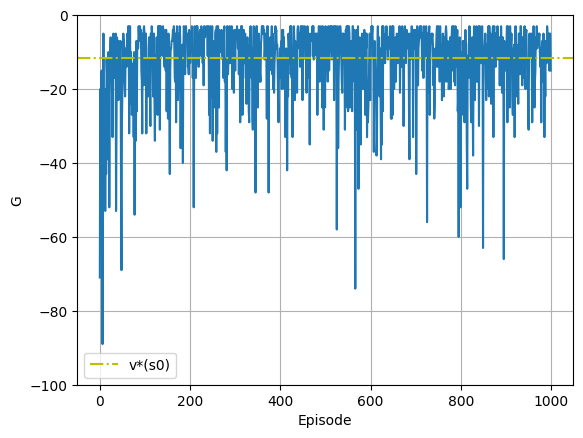

In [79]:
plt.plot(total_reward) 
plt.axhline(y=-11.6, color='y', linestyle='-.', label='v*(s0)')
plt.xlabel('Episode')
plt.ylabel('G')
plt.legend(loc='best')
plt.ylim(-100, 0)
plt.grid(True)

In [80]:
print('Estimated theta:', agent.policy.theta)
print('Probability for LEFT: %.2f' % ( agent.policy.a_probs(0)[LEFT]))
print('Probability for RIGHT: %.2f' % ( agent.policy.a_probs(0)[RIGHT]))

Estimated theta: [ 0.3324313 -0.3324313]
Probability for LEFT: 0.34
Probability for RIGHT: 0.66


__TASK__:

1. Experiment with the step sizes. And number of episodes. Compare your results with Figure 13.2 in the textbook (note that this one shows the average over 100 runs)

# 4. One-step Actorc-Critic <a id="sec4">

We will now implement a one-step actor-critic agent. See slides in Lecture 9 or the textbook Chapter 13.5 (note, we here use $\gamma = 1$).

__TASK__: Implement the learn function below. Note that we will still use the classes `PolicySC` and `ValueFunctionSC` for parameterization of the policy and value function.

In [89]:
class ActorCritic:
    
    def __init__(self, policy, valuefunc, alpha_theta=(2**-13), alpha_w = (2**-6)):
        
        self.alpha_theta = alpha_theta
        self.alpha_w = alpha_w
        
        self.policy = policy
        self.valuefunc = valuefunc
        
    def act(self, state):
        return self.policy.act(state)
        
    def learn(self, state, action, reward, state_next, terminated):
        
        # TODO Implement the learn method for actor-critic
        if terminated:
            delta = reward - self.valuefunc.value(state)
        else: 
            delta = reward + self.valuefunc.value(state_next) - self.valuefunc.value(state)
        self.valuefunc.w += self.alpha_theta * delta * self.valuefunc.grad(state)
        self.policy.theta += self.alpha_w * delta * self.policy.ln_grad(state, action)


Since we do not have to wait until the end of the episode when we use the one-step actor-critic, we need a new `trainAC` function for training the agent. 

In [90]:
def trainAC(env, agent, n_episodes):
    
    total_reward = -1000*np.ones(n_episodes)
    print('Episode 1')
    for i in range(n_episodes):
        
        if ((i+1) % 100) == 0:
            clear_output(wait=True)
            print('Episode', i+1)
            
        state, info = env.reset()
        
        terminated = truncated = False
        total_reward[i] = 0
        while not terminated and not truncated:
            action = agent.act(state)
            state_next, reward, terminated, truncated, info = env.step(action)
            
            total_reward[i] += reward
            
            agent.learn(state, action, reward, state_next, terminated)
            state = state_next
            
        if truncated:
            print('An episode was truncated, so the training stop at episode', i)
            return (total_reward, True)
        
    return (total_reward, False)

Let us now train the actor-critic agent

In [91]:
env_train = gym.make('ShortCorridor-v0')

In [109]:
n_episodes = 1000
alpha_theta = 2**(-14)
alpha_w = 2**(-10)
policy = PolicySC()
valuefunc = ValueFunctionSC()
agent = ActorCritic(policy, valuefunc, alpha_theta=alpha_theta, alpha_w = alpha_w)
total_reward, truncated = trainAC(env_train, agent, n_episodes)
print('Finished')

Episode 1000
Finished


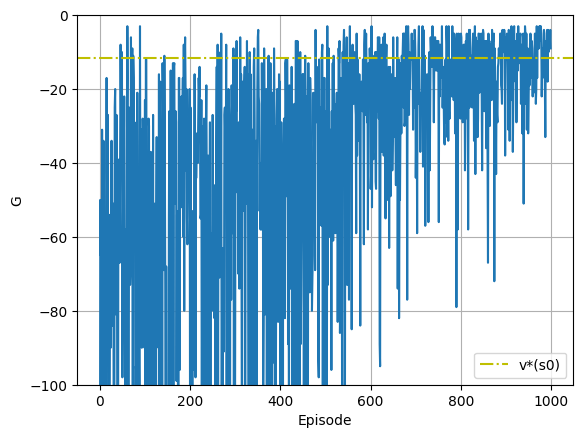

In [110]:
plt.plot(total_reward) 
plt.axhline(y=-11.6, color='y', linestyle='-.', label='v*(s0)')
plt.xlabel('Episode')
plt.ylabel('G')
plt.legend(loc='best')
plt.ylim(-100, 0)
plt.grid(True)

In [111]:
print('Estimated theta:', agent.policy.theta)
print('Probability for LEFT: %.2f' % ( agent.policy.a_probs(0)[LEFT]))
print('Probability for RIGHT: %.2f' % ( agent.policy.a_probs(0)[RIGHT]))

Estimated theta: [-0.2092641  0.2092641]
Probability for LEFT: 0.60
Probability for RIGHT: 0.40


__TASK__: Try different step sizes, compare with results from REINFORCE with baseline. Remember to re-run several times to see how the results vary.